# Imports

In [21]:
import pandas as pd


# Getting Sleep Data Ready

In [22]:
sleep = pd.read_csv('../data/nt_y_fitb_slp_d.csv')

print("Sleep data columns:", sleep.columns.tolist())


Sleep data columns: ['src_subject_id', 'eventname', 'fit_ss_sleepdate', 'fit_ss_wkno', 'fit_ss_weekday', 'fit_ss_weekend_ind', 'fit_ss_protocol_date', 'fit_ss_protocol_wear', 'fit_ss_first_inbed_minutes', 'fit_ss_first_sleep_minutes', 'fit_ss_outbed_minutes', 'fit_ss_wakeup_minutes', 'fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count', 'fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']


In [23]:
demographic_data = ['src_subject_id', 'eventname']
average_sleep_data = ['fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count',   'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem', 'fit_ss_avg_hr_wake']

# Filter the sleep data to include only the demographic and average sleep columns
filtered_sleep_avg = sleep[demographic_data + average_sleep_data]

# look for missing values in the filtered sleep data
missing_values = filtered_sleep_avg.isnull().sum()
# Print the missing values
print("Missing values in filtered sleep data:")
print(missing_values[missing_values > 0])

# unique sunject IDs
unique_subject_ids = filtered_sleep_avg['src_subject_id'].unique()
print("Unique subject IDs in filtered sleep data:")
print(len(unique_subject_ids))

# find rows with all values available
complete_rows = filtered_sleep_avg.dropna()
filtered_sleep_avg = filtered_sleep_avg.dropna()
# Print the number of complete rows
print("Number of complete rows in filtered sleep data:")
print(len(complete_rows))

Missing values in filtered sleep data:
fit_ss_avg_hr_deep    137
fit_ss_avg_hr_rem     306
fit_ss_avg_hr_wake     39
dtype: int64
Unique subject IDs in filtered sleep data:
6793
Number of complete rows in filtered sleep data:
109593


# Getting Depression Data Ready

In [24]:
depression = pd.read_csv('../data/mh_y_ksads_dep.csv')
depression = depression[depression['eventname'] == '2_year_follow_up_y_arm_1']
unique_subject_ids = depression['src_subject_id'].unique()
print(f"Number of unique subject IDs: {len(unique_subject_ids)}")

print(f"Dataset shape: {depression.shape}")
print(f"Total columns: {len(depression.columns)}")


Number of unique subject IDs: 10814
Dataset shape: (10814, 93)
Total columns: 93


In [25]:
core_symptoms = ['ksads_dp_raw_95_t', 'ksads_dp_raw_98_t', 'ksads_dp_raw_101_t']
demographic_data = ['src_subject_id', 'eventname']

depression = depression[demographic_data + core_symptoms]

depression['depression_severity'] = depression[core_symptoms].sum(axis=1)
depression['depression_outcome'] = (depression['depression_severity'] > 2).astype(int)

In [26]:

depression_outcome = (depression[core_symptoms] >= 2).any(axis=1)

# Severity outcome: Total depression severity
depression_severity = depression[core_symptoms].sum(axis=1)

# Check how many subjects have valid outcome data
has_any_core_data = depression[core_symptoms].notna().any(axis=1)
print(f"Subjects with any core symptom data: {has_any_core_data.sum()}")

# Depression outcome statistics
depression_count = depression_outcome.sum()
total_with_data = has_any_core_data.sum()
print(f"\nDepression outcomes:")
print(f"Subjects with depression (≥2 on any core symptom): {depression_count}/{total_with_data} ({depression_count/total_with_data*100:.1f}%)")

Subjects with any core symptom data: 10814

Depression outcomes:
Subjects with depression (≥2 on any core symptom): 2352/10814 (21.7%)


In [27]:
essential_cols = [
    'src_subject_id',
    'eventname',       # For merging with sleep data                  # Demographics
    'depression_outcome',        # Your main ML target
    'depression_severity'       # Alternative target
]

depression_ml = depression[essential_cols]
# Quick summary
print(f"\nDataset ready for sleep data merge:")
print(f"- Unique subjects: {depression_ml['src_subject_id'].nunique()}")
print(f"- Depression outcomes: {depression_ml['depression_outcome'].value_counts()}")


Dataset ready for sleep data merge:
- Unique subjects: 10814
- Depression outcomes: depression_outcome
0    7983
1    2831
Name: count, dtype: int64


# Combining the two datasets

In [28]:
# merge sleep and depression dataset on 'src_subject_id' and 'eventname'
merged_data = pd.merge(filtered_sleep_avg, depression_ml, on=['src_subject_id', 'eventname'], how='inner')
# Check the merged dataset
print(f"\nMerged dataset shape: {merged_data.shape}")
print(f"Unique subjects in merged dataset: {merged_data['src_subject_id'].nunique()}")


Merged dataset shape: (82061, 13)
Unique subjects in merged dataset: 6008


In [29]:
# check the split of depression outcomes in the merged dataset in percentage

print(f"\nDepression outcomes in merged dataset:")
print(merged_data['depression_outcome'].value_counts(normalize=True) * 100)


Depression outcomes in merged dataset:
depression_outcome
0    76.014185
1    23.985815
Name: proportion, dtype: float64



Classification report (test set):
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     12476
           1       0.00      0.00      0.00      3937

    accuracy                           0.76     16413
   macro avg       0.38      0.50      0.43     16413
weighted avg       0.58      0.76      0.66     16413

ROC AUC: 0.554


/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

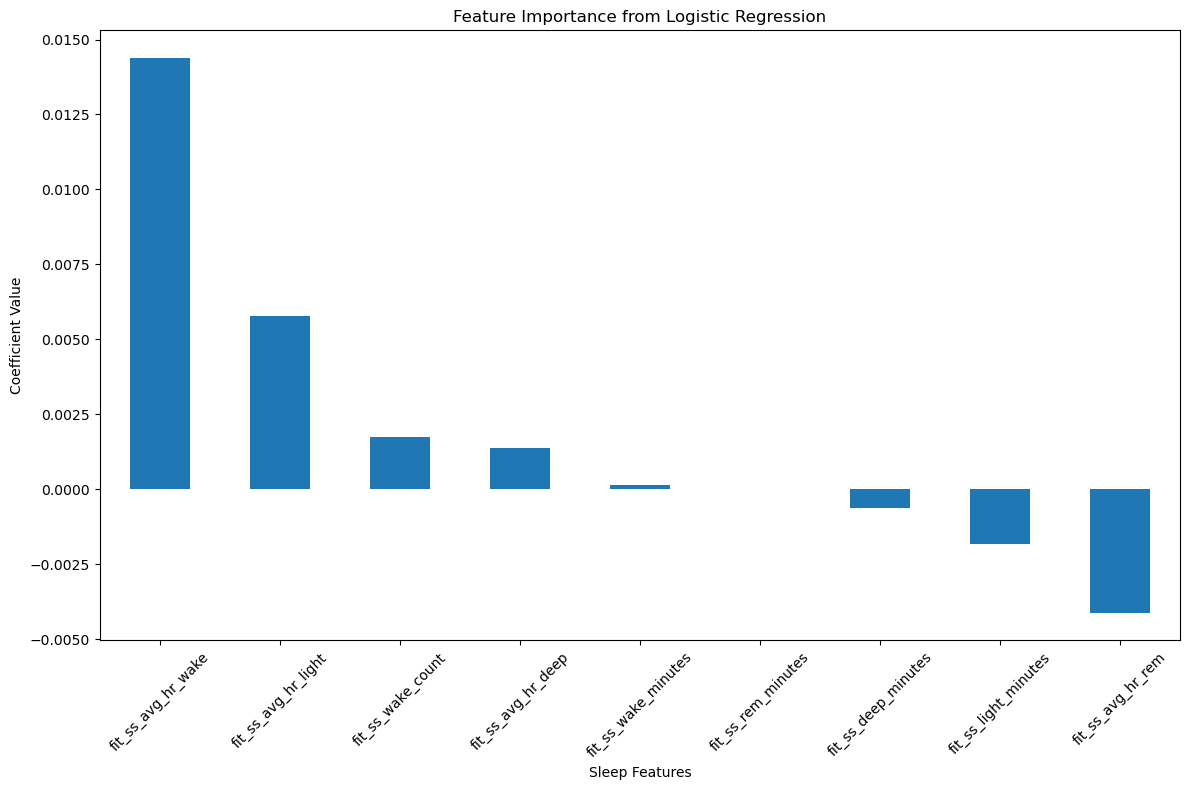

In [30]:
# Basic model: Logistic Regression to predict depression outcome from sleep data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Select features: use all sleep columns (exclude id/event/outcome columns)
sleep_features = [col for col in filtered_sleep_avg.columns if col not in ['src_subject_id', 'eventname']]
X = merged_data[sleep_features]
y = merged_data['depression_outcome']

# Drop rows with missing values in features or target
X = X.copy()
y = y.copy()
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

# build graphs to visualize the results
import matplotlib.pyplot as plt
import seaborn as sns
# Plot feature importances
plt.figure(figsize=(12, 8))
importance = pd.Series(clf.coef_[0], index=sleep_features).sort_values(ascending=False)
importance.plot(kind='bar')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Sleep Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()